In [1]:
import pandas as pd
from sqlalchemy import create_engine
from functools import reduce
import re

In [2]:
def get_tables(path):
    """"
    :param: path of the data base
    :return: data frame with all the data, united by 'uuid'.
    """
    engine = create_engine(f'sqlite:///{path}')
    df_personal_info = pd.read_sql("SELECT * FROM personal_info", engine)
    df_country_info = pd.read_sql("SELECT * FROM country_info", engine)
    df_career_info = pd.read_sql("SELECT * FROM career_info", engine)
    df_poll_info = pd.read_sql("SELECT * FROM poll_info", engine)

    # getting the complete data frame
    dfs_list = [df_personal_info, df_country_info, df_career_info, df_poll_info]
    df_info = reduce(lambda left, right: pd.merge(left, right, on='uuid'), dfs_list)

    # exporting the data frame to processed data folder.
    #df_info.to_csv(f'../../data/processed/info_dataframe.csv', index=True)

    return df_info

In [3]:
df_complete = get_tables('../data/raw/raw_data_project_m1.db')

In [4]:
# cleaning personal_info gender column.
df_complete['gender'] = df_complete['gender'].astype("string").str.capitalize()
df_complete['gender'] = df_complete['gender'].replace('Fem', 'Female')

In [5]:
# cleaning personal_info age_group column.
df_complete['age_group'] = df_complete['age_group'].replace('juvenile', '14_25')

In [6]:
# cleaning personal_info age column.
df_complete['age'] = df_complete['age'].astype("string")
df_complete['age'] = df_complete['age'].str.replace(' years old', '')

for x in range(1980, 2050):
    df_complete['age'] = df_complete['age'].str.replace(f'{x}', f'{2016 - x}')

df_complete['age'] = df_complete['age'].astype('int64')

In [7]:
#Hacemos filtro para ver mejor los elemntos correspondientes a 'juvenile'. Max y min pertenecen al bin 14-25, 
#porque 2016-1991 = 25 y 2016-2002=14, por lo que entendemos que todos pertecen a la msima categoría.
#juvenile_filter = df_personal_info['age_group'].str.contains("juvenile")
#print(df_personal_info[juvenile_filter].max())
#print(df_personal_info[juvenile_filter].min())

In [8]:
# cleaning country_info rural column.
df_complete['rural'] = df_complete['rural'].str.lower()

In [9]:
# cleaning career_info dem_education_level column.
df_complete['dem_education_level'] = df_complete['dem_education_level'].replace('no', 'no education')
df_complete['dem_education_level'] = df_complete['dem_education_level'].fillna('no education')

In [10]:
# cleaning career_info dem_education_level column.
df_complete['dem_education_level'] = df_complete['dem_education_level'].replace('no', 'no education')
df_complete['dem_education_level'] = df_complete['dem_education_level'].fillna('no education')

In [11]:
# cleaning def_has_chidren
df_complete['dem_has_children'] = df_complete['dem_has_children'].str.lower()

In [12]:
#connecting API
import json
import requests

## API

In [13]:
response = requests.get(f'http://api.dataatwork.org/v1/jobs') 
json_data = response.json()
#problema: solo me salen 20

In [14]:
#response = requests.get('http://api.dataatwork.org/v1/jobs/uuid')
#results = response.json()
#print(len(results))
#solo saca 21 pero necesito más. lo que vamos a hacer es que nos saque los datos 
# para cada uuid, para eso necesitamos saber cuántos uuids hay.

In [15]:
job_code_unique = df_complete['normalized_job_code'].unique()
#len(job_code_unique)

In [16]:
list_uuid_key = []
list_title_value = []

for code in job_code_unique:
    response = requests.get(f'http://api.dataatwork.org/v1/jobs/{code}').json()
    if list(response.keys())[0] == 'error':
        pass
    else:
        list_uuid_key.append(response['uuid'])
        list_title_value.append(response['title'])

In [17]:
dict_uuid_jobs_title = dict(zip(list_uuid_key , list_title_value))

In [18]:
df_complete['Job Title'] = df_complete['normalized_job_code']

for uuid, title in dict_uuid_jobs_title.items():
    df_complete.loc[df_complete['normalized_job_code'] == uuid , 'Job Title'] = title

In [19]:
df_complete['Job Title'] = df_complete['Job Title'].fillna('No job')

## Web scraping

In [20]:
import requests
from bs4 import BeautifulSoup

In [21]:
url = 'https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes'
html = requests.get(url).content
soup = BeautifulSoup(html, 'html.parser')

In [22]:
table = soup.find_all('div' , {'class': 'mw-content-ltr'})[0]
table_countries = table.find_all('table')
all_info_countries = [info.text for info in table_countries]

In [23]:
# cleaning the info countries.
countries_without_spaces = [re.sub(r'\s' , '' , x) for x in all_info_countries]
countries_without_symbols = [re.sub(r'\*' , '' , x) for x in countries_without_spaces]
countries_without_squarebrackets = [re.sub(r'\[\d\]' , '' , x) for x in countries_without_symbols]
countries_clean = ''.join(countries_without_squarebrackets) #unimos todo en una string para poder hacer split

In [24]:
country_value = re.split(r'\(\w{0,7}\)' , countries_clean)
country_key = re.findall(r'\(\w{0,7}\)' , countries_clean) #extract the codes
country_key = [re.sub(r'\(|\)' , '' , x) for x in country_key] #without parenthesis.
dic_countries = dict(zip(country_key, country_value))

In [25]:
df_complete['Country'] = df_complete['country_code']

for code, name in dic_countries.items():
    df_complete.loc[df_complete['country_code'] == code , 'Country'] = name

## Renaming and adding Quality and Percentage columns

In [26]:
# renaming columns
df_complete.rename(columns={'age': 'Age',
                           'gender': 'Gender',
                           'dem_has_children': 'Childrens',
                           'age_group': 'Age Group',
                           'country_code': 'Country Code',
                           'rural': 'Area',
                           'dem_education_level': 'Education Level',
                           'dem_full_time_job': 'Full Time Job',
                           'normalized_job_code': 'Job Code',
                           'question_bbi_2016wave4_basicincome_awareness': 'Q1: awareness',
                           'question_bbi_2016wave4_basicincome_vote': 'Q2: vote',
                           'question_bbi_2016wave4_basicincome_effect': 'Q3: effect',
                           'question_bbi_2016wave4_basicincome_argumentsfor': 'Q4: arguments for',
                           'question_bbi_2016wave4_basicincome_argumentsagainst': 'Q5: arguments against'}, inplace=True)

In [27]:
df_complete['Quantity'] = df_complete.groupby('uuid')['uuid'].transform('count').astype("int64")

In [28]:
# adding percentage column
# votos por país
list_countries =df_complete['Country'].unique().tolist()
list_countries

['Austria',
 'Belgium',
 'Bulgaria',
 'Cyprus',
 'Czechia',
 'Germany',
 'Denmark',
 'Estonia',
 'Spain',
 'Finland',
 'France',
 'GB',
 'GR',
 'Croatia',
 'Hungary',
 'Ireland',
 'Italy',
 'Lithuania',
 'Luxembourg',
 'Latvia',
 'Malta',
 'Netherlands',
 'Poland',
 'Portugal',
 'Romania',
 'Sweden',
 'Slovenia',
 'Slovakia']

In [29]:
# total people per country column.
df_complete['Total Votes Per Country'] = 0

for country in list_countries:
    df_complete.loc[df_complete['Country'] == country , 'Total Votes Per Country'] = df_complete.loc[df_complete['Country'].str.contains(country) , 'Quantity'].sum()

In [30]:
df_complete['Percentage'] = (df_complete['Total Votes Per Country'] / df_complete['Total Votes Per Country'].sum()) 
#df_complete['Percentage'] = df_complete['Percentage'].astype(float).map(lambda x: '{:.4%}'.format(x)) # adding the %

In [31]:
df_result = df_complete[['Country', 'Job Title', 'Age', 'Quantity', 'Percentage']].groupby(['Country', 'Job Title'], as_index=False).agg(Age = ('Age', 'mean'), Quantity = ('Quantity', 'sum'), Percentage=('Percentage', 'sum'))
#df_result['Age'] = df_result['Age'].astype(float).round(3)
df_result = df_result.round({'Age': 2, 'Percentage': 6})
df_result

,Country,Job Title,Age,Quantity,Percentage
0,Austria,Automatic Data Processing Customer Liaison (AD...,35.50,2,0.000031
1,Austria,Automatic Data Processing Planner,52.50,2,0.000031
2,Austria,Automatic Data Processing Systems Security Spe...,37.00,2,0.000031
3,Austria,Clinical Data Specialist,39.00,1,0.000015
4,Austria,Computer or Data Processing Systems Consultant,44.67,3,0.000046
...,...,...,...,...,...
1861,Sweden,Naval Tactical Data System--Combat Information...,27.00,1,0.000020
1862,Sweden,No job,31.07,81,0.001648
1863,Sweden,Oracle Database Administrator (Oracle DBA),35.00,1,0.000020
1864,Sweden,SQL Database Administrator,45.00,1,0.000020


In [32]:
df_result[df_result['Country'] == 'Spain']

,Country,Job Title,Age,Quantity,Percentage
1669,Spain,Analytical Data Miner,22.00,1,0.000117
1670,Spain,Automatic Data Processing Customer Liaison (AD...,39.73,11,0.001285
1671,Spain,Automatic Data Processing Planner,40.00,9,0.001051
1672,Spain,Automatic Data Processing Planner (ADP Planner),46.00,11,0.001285
1673,Spain,Automatic Data Processing Systems Security Spe...,46.43,7,0.000818
...,...,...,...,...,...
1793,Spain,SQL Database Administrator,49.38,8,0.000935
1794,Spain,Scientific Database Curator,44.00,2,0.000234
1795,Spain,Survey Data Technician,19.00,1,0.000117
1796,Spain,Voice and Data Technician,32.50,2,0.000234


In [33]:
#bonus 1: table about votes.

In [34]:
# cleaniin Q3 column
df_complete['Q3: effect'] = df_complete['Q3: effect'].astype("string")
df_complete['Q3: effect'] = df_complete['Q3: effect'].replace("‰Û_ ", "")

In [35]:
df_complete['Q3: effect'] = [re.sub(r'\‰Û_', '', x) for x in df_complete['Q3: effect']]

In [36]:
df_complete.head(2)

,uuid,Age,Gender,Childrens,Age Group,Country Code,Area,Education Level,Full Time Job,Job Code,Q1: awareness,Q2: vote,Q3: effect,Q4: arguments for,Q5: arguments against,Job Title,Country,Quantity,Total Votes Per Country,Percentage
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,61,Male,no,40_65,AT,countryside,no education,no,None,I know something about it,I would not vote,None of the above,None of the above,None of the above,No job,Austria,1,133,0.000015
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,57,Male,yes,40_65,AT,urban,high,yes,861a9b9151e11362eb3c77ca914172d0,I understand it fully,I would probably vote for it,A basic income would not affect my work choices,It increases appreciation for household work a...,It might encourage people to stop working,Automatic Data Processing Planner,Austria,1,133,0.000015


In [37]:
# Q4 vamos a unirlo todo en una sola lista para ver los valores únicos.
arguments_for = [info for info in df_complete['Q4: arguments for']]

In [38]:
def convert_list_to_string(org_list, seperator=' '):
    """ Convert list to string, by joining all item in list with given separator.
        Returns the concatenated string """
    return seperator.join(org_list)

In [39]:
all_arguments = convert_list_to_string(arguments_for)

In [40]:
arguments_split_mayus = re.findall('[A-Z][^A-Z]*', all_arguments)

In [41]:
arguments_without_verticalbar = [re.sub('\ \| +', '', x) for x in arguments_split_mayus]

In [42]:
arguments_cleaned = [re.sub(' [^ ]*$', '', x) for x in arguments_without_verticalbar]
arguments_cleaned_set = set(arguments_cleaned)

In [43]:
arguments_cleaned_set

{'It creates more equality of',
 'It creates more equality of opportunity',
 'It encourages financial independence and',
 'It encourages financial independence and self-responsibility',
 'It increases appreciation for household work and',
 'It increases appreciation for household work and volunteering',
 'It increases solidarity, because it is funded by',
 'It increases solidarity, because it is funded by everyone',
 'It reduces anxiety about financing basic',
 'It reduces anxiety about financing basic needs',
 'It reduces bureaucracy and administrative',
 'It reduces bureaucracy and administrative expenses',
 'None of the above'}

In [44]:
more_equality = sum(map(lambda x : x=='It creates more equality of' or x=='It creates more equality of opportunity', arguments_cleaned))
financial_independence = sum(map(lambda x : x == 'It encourages financial independence and' or x == 'It encourages financial independence and self-responsibility', arguments_cleaned))
household_appreciation = sum(map(lambda x : x== 'It increases appreciation for household work and' or x == 'It increases appreciation for household work and volunteering', arguments_cleaned))
solidarity = sum(map(lambda x : x== 'It increases solidarity, because it is funded by' or x == 'It increases solidarity, because it is funded by everyone', arguments_cleaned))
reduces_anxiety = sum(map(lambda x : x== 'It reduces anxiety about financing basic' or x == 'It reduces anxiety about financing basic needs', arguments_cleaned))
reduces_boreaucracy_expenses = sum(map(lambda x : x== 'It reduces bureaucracy and administrative' or x == 'It reduces bureaucracy and administrative expenses', arguments_cleaned))
none_of_above = sum(map(lambda x: x == 'None of the above', arguments_cleaned))

In [45]:
#number_of_votes = pd.DataFrame(votes, columns = ['Number of pro arguments', 'Number of cons arguments']
#votes = [['In favor', number_pro_arguments], ['Against': Y]]

In [46]:
number_pro_favor_votes = more_equality + financial_independence + household_appreciation + solidarity + reduces_anxiety + reduces_boreaucracy_expenses
number_pro_against_votes = none_of_above

In [47]:
#Q5: hacemos todo el proceso de nuevo

In [48]:
arguments_against = [info for info in df_complete['Q5: arguments against']]
arguments_against_together = ' '.join(arguments_against)
arguments_against_split_mayus = re.findall('[A-Z][^A-Z]*', arguments_against_together)
arguments_against_without_verticalbar = [re.sub('\ \| +', '', x) for x in arguments_against_split_mayus]
arguments_against_cleaned = [re.sub(' [^ ]*$', '', x) for x in arguments_against_without_verticalbar]
arguments_against_cleaned_set = set(arguments_against_cleaned)

In [49]:
arguments_against_cleaned_set

{'Foreigners might come to my country and take advantage of the',
 'Foreigners might come to my country and take advantage of the benefit',
 'It increases dependence on the',
 'It increases dependence on the state',
 'It is against the principle of linking merit and',
 'It is against the principle of linking merit and reward',
 'It is impossible to',
 'It is impossible to finance',
 'It might encourage people to stop',
 'It might encourage people to stop working',
 'None of the above',
 'Only the people who need it most should get something from the',
 'Only the people who need it most should get something from the state'}

In [50]:
foreigners = sum(map(lambda x : x=='Foreigners might come to my country and take advantage of the' or x=='Foreigners might come to my country and take advantage of the benefit', arguments_against_cleaned))
state_dependence = sum(map(lambda x : x == 'It increases dependence on the' or x == 'It increases dependence on the state', arguments_against_cleaned))
against_merit = sum(map(lambda x : x== 'It is against the principle of linking merit and' or x == 'It is against the principle of linking merit and reward', arguments_against_cleaned))
impossible_finance = sum(map(lambda x : x== 'It is impossible to' or x == 'It is impossible to finance', arguments_against_cleaned))
stop_working = sum(map(lambda x : x== 'It might encourage people to stop' or x == 'It might encourage people to stop working', arguments_against_cleaned))
only_needed = sum(map(lambda x : x== 'Only the people who need it most should get something from the' or x == 'Only the people who need it most should get something from the state', arguments_against_cleaned))
none_of_above_ag = sum(map(lambda x: x == 'None of the above', arguments_against_cleaned))

In [51]:
number_cons_favor = foreigners + state_dependence + against_merit + impossible_finance + stop_working + only_needed
number_cons_against = none_of_above_ag

In [52]:
votes = [['In favor', number_pro_favor_votes, number_cons_favor], ['Against', number_pro_against_votes, number_cons_against]]
number_of_votes = pd.DataFrame(votes, columns=['Position', 'Number of pro arguments', 'Number of cons arguments'])

In [53]:
number_of_votes

,Position,Number of pro arguments,Number of cons arguments
0,In favor,14571,18374
1,Against,2163,1381


## BONUS 2

In [54]:
unique_jobs = df_complete['Job Title'].unique()

In [146]:
list_jobs_key = []
list_skills_values = []

for code in job_code_unique:
    response_skills = requests.get(f'http://api.dataatwork.org/v1/jobs/{code}/related_skills').json()
    if list(response_skills.keys())[0] == 'error':
        pass
    else:
        list_jobs_key.append(response_skills['job_uuid'])
        list_skills_values.append(response_skills['skills'])
        
        
print(list_skills_values)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [94]:
df_skills = pd.DataFrame(list_skills_values[0])
df_skills

,skill_uuid,skill_name,skill_type,description,normalized_skill_name,importance,level
0,b3cb1294905e001d3d611bff1de3962c,computers and electronics,knowledge,"knowledge of circuit boards, processors, chips...",computers and electronics,4.61,5.79
1,500018df958f2b9f8b387cf5637a0a04,english language,knowledge,knowledge of the structure and content of the ...,english language,4.01,4.54
2,20784bf09c9fe614603ad635e6093ede,critical thinking,skill,using logic and reasoning to identify the stre...,critical thinking,3.75,4.50
3,0194023051cb666af3d2c4761d894957,oral comprehension,ability,the ability to listen to and understand inform...,oral comprehension,3.62,4.50
4,d66da8698b5a37186143205b78c73f7d,problem sensitivity,ability,the ability to tell when something is wrong or...,problem sensitivity,3.62,4.12
...,...,...,...,...,...,...,...
114,14761de245bcd6eba056fe5091f34407,gross body equilibrium,ability,the ability to keep or regain your body balanc...,gross body equilibrium,1.00,0.00
115,b18b8fef2d7455abdf73295dc7d269fe,night vision,ability,the ability to see under low light conditions.,night vision,1.00,0.00
116,2e438c6f4e1239baea1d6e6090c924de,peripheral vision,ability,the ability to see objects or movement of obje...,peripheral vision,1.00,0.00
117,431209d2171022ca1ca9c8866e111649,glare sensitivity,ability,the ability to see objects in the presence of ...,glare sensitivity,1.00,0.00


In [235]:
list_of_skills = df_skills['skill_name'].tolist()

In [236]:
#damos por hecho que la skill más importante es la primera y solo nos quedamos con conesa.
dict_job_skills_title = dict(zip(list_jobs_key , list_of_skills))

In [237]:
dict_job_skills_title

{'861a9b9151e11362eb3c77ca914172d0': 'computers and electronics',
 '049a3f3a2b5f85cb2971ba77ad66e10c': 'english language',
 'f4b2fb1aa40f661488e2782b6d57ad2f': 'critical thinking',
 '27af8700f5577cec835acee2cb90a2ff': 'oral comprehension',
 'c1b670eba9ccb65e7c99f7da116d5b9c': 'problem sensitivity',
 'd71c4164c99a5f9bca773e755a72f40f': 'information ordering',
 '2ee80cf30e2483dfe0947adc0428f8c5': 'customer and personal service',
 '897ef18a9321616495831a4b4b0c1bb2': 'mathematics',
 'a003702c0cea282e17967772dd83de5e': 'reading comprehension',
 '04c82eae29e1c4a30eac0710b74ab276': 'active listening',
 'fcaf4aac737e53ad24b9f32f08b8740f': 'speaking',
 '3833bd699e7afe4665b595f282da0387': 'systems analysis',
 '474b962c13632a04e42a546be4f11dbb': 'written comprehension',
 'dac2e921c1f887d9efc4c06fa33c1397': 'fluency of ideas',
 '996da29c84f5eed00da40c230f4c4078': 'deductive reasoning',
 'cc2b26cc436bea36bda3bdd7367c411a': 'category flexibility',
 '25fe195cbf915c0824fa6c44e6d0008c': 'near vision',


In [238]:
df_complete['Skills'] = df_complete['Job Code']

for job_uuid, skill in dict_job_skills_title.items():
       #if job_uuid == df_complete['Job Code'][0]:
        df_complete.loc[df_complete['Job Code'] == job_uuid , 'Skills'] = skill

In [331]:
df_complete['Skills'] = df_complete['Skills'].str.replace('\d+', '')
df_complete['Skills'] = df_complete['Skills'].str.replace('abfbdfebaeebea', '')
df_complete['Skills'] = df_complete['Skills'].str.replace('aceadcddddbafaab', '')
df_complete['Skills'] = df_complete['Skills'].str.replace('aceeaaeeaaaecd', '')


In [436]:
df_bonus3 = df_complete[['Education Level', 'Skills']].groupby('Education Level', as_index=False).count()

In [442]:
df_bonus3.sort_values(by='Skills', ascending=False)

,Education Level,Skills
0,high,2450
2,medium,2111
1,low,777
3,no education,364


In [391]:
df_complete['Skills count'] = df_complete.groupby('Skills')['Skills'].transform('count')

In [453]:
group_1 = df_complete.groupby(['Education Level', 'Skills']).agg({'Skills': 'count'})
group_2 = group_1['Skills'].groupby('Education Level', group_keys=False)
group_3 = group_2.apply(lambda x: x.sort_values(ascending=True).head(10))

In [454]:
group_4 = pd.DataFrame(group_3) 
group_4

Skills
Education Level Skills                               
high            trunk strength                      1
                philosophy and theology             1
                operation and control               1
                night vision                        1
                debcfcbaef                          2
                cfbabaccfaddc                       2
                static strength                     2
                bbcaffccfac                         2
                stamina                             2
                dynamic strength                    2
low             equipment selection                 1
                wrist-finger speed                  1
                customer and personal service       1
                debcfcbaef                          1
                deductive reasoning                 1
                economics and accounting            1
                edaebadacdf                         1
                explosive strength                  1
                ffbecffcdcbe                        1
                sound localization                  1
medium          ceeebdfceb                          1
                debcfcbaef                          1
                law and government                  1
                foreign language                    1
                fddaadaabfaecafcc                   2
                cebbfbfdddde                        2
                cfbabaccfaddc                       2
                fbedafbeebcba                       2
                finger dexterity                    2
                spatial orientation                 2
no education    fbedafbeebcba                       1
                dynamic flexibility                 1
                night vision                        1
                deductive reasoning                 1
                debcfcbaef                          1
                history and archeology              1
                customer and personal service       1
                oral expression                     1
                trunk strength                      1
                peripheral vision                   1

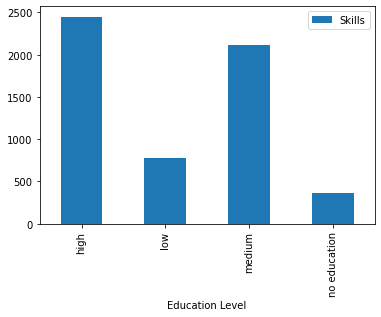

In [443]:
skills_graph = df_bonus3.plot(x='Education Level', y='Skills', kind='bar');

In [451]:
skills_graph.to_clipboard('/data/results/skills_level_education.png')

AttributeError: 'AxesSubplot' object has no attribute 'to_clipboard'